<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

Ahora, cargamos los datos de prueba en los arreglos `X_train` y `y_train`:

In [23]:
df    = pd.read_csv('demanda.csv')

## Procesamos datos de entrenamiento 
dftrain = df.loc[df.iloc[:,20].isin(['T'])] ## 'T' = training set
y_train = dftrain['Y'].to_numpy() 
X_train = dftrain[['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10']].to_numpy() ## Regresores

## Procesamos datos de prueba 
dftest = df.loc[df.iloc[:,20].isin(['F'])] ## 'F' = test set
y_test = dftest['Y'].to_numpy()
X_test = dftest[['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10']].to_numpy() ## Regresores

In [24]:
def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

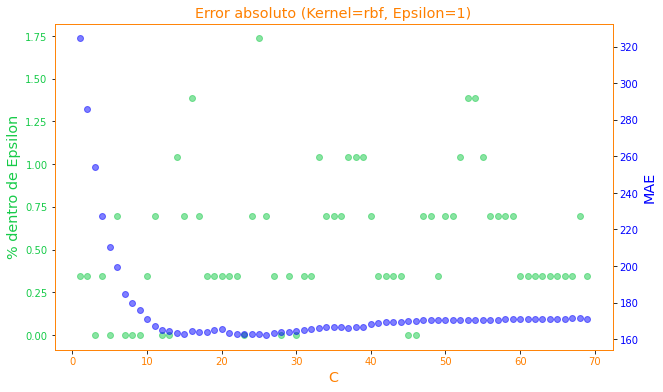

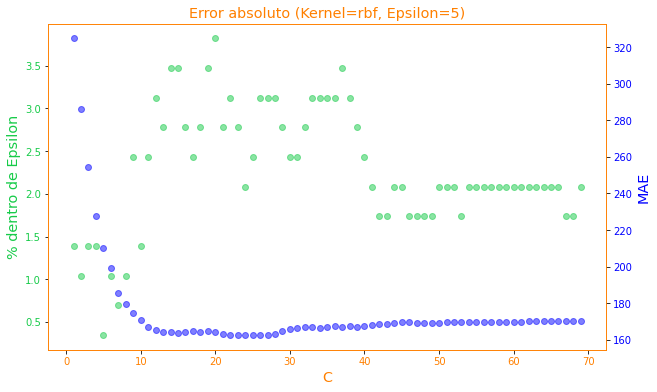

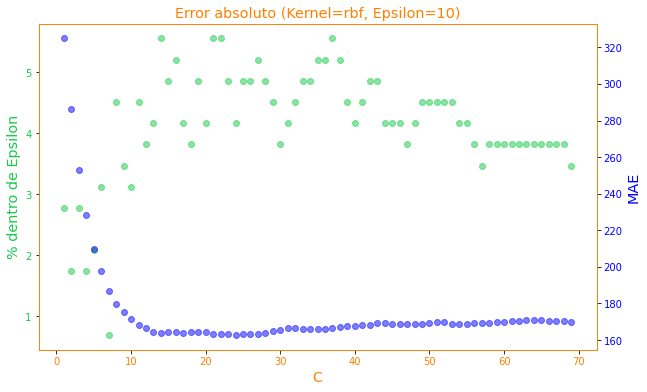

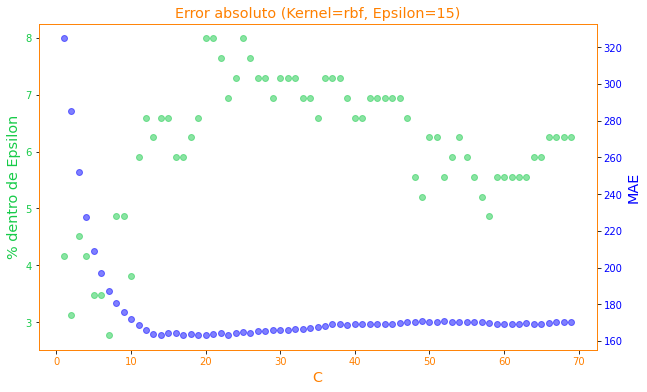

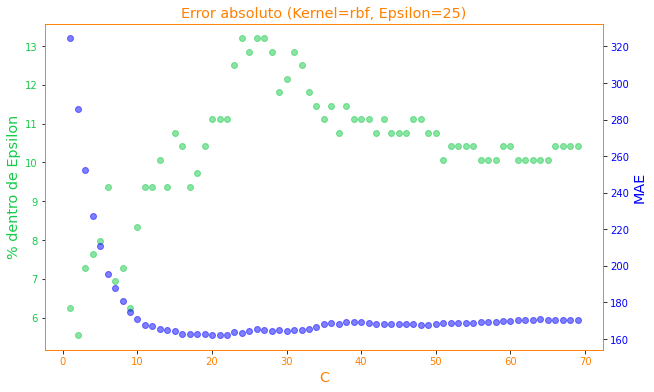

In [25]:
kernel_list  = ['rbf'] #
epsilon_list = [1,5,10,15,25]

for k in kernel_list:
    for e in epsilon_list:
        mae_svm = []; mse_svm = []; mape_svm = []; Clist = []; perc_within_eps_list = []    
        for c in range(1, 70, 1):
            Clist.append(c)
            model = svm.SVR(kernel=k, C=c, epsilon=e)
            model.fit(X_train, y_train)
            #r_sq = model.score(X_test, y_test)
            #print('coefficient of determination:', r_sq)
            
            y_pred = model.predict(X_test)
            mae_svm.append(trunc(mean_absolute_error(y_test,y_pred),4))
            mse_svm.append(trunc(mean_squared_error(y_test,y_pred),4))
            mape_svm.append(trunc(mean_absolute_percentage_error(y_test,y_pred),4))
            
            perc_within_eps = 100 * np.sum(abs(y_test-y_pred) <= e) / len(y_test)
            perc_within_eps_list.append(perc_within_eps)
            
        CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-";c
        fig, ax1 = plt.subplots(figsize=(10,6))
        
        plt.title('Error absoluto (Kernel=' + str(k) + ', Epsilon=' + str(e) +')',fontsize='x-large',color = LETRASNARA)
        ax1.set_xlabel('C', color=LETRASNARA, fontsize='x-large')
        ax1.set_ylabel('% dentro de Epsilon', color=VERDE,fontsize='x-large')
        ax1.scatter(Clist, perc_within_eps_list, color=VERDE, alpha = 0.5)
        ax1.tick_params(axis='y', labelcolor=VERDE)
        ax1.tick_params(axis='x', labelcolor=LETRASNARA)
        #plt.tick_params(colors = LETRASNARA, which='both')
        ax1.spines['bottom'].set_color(LETRASNARA)
        ax1.spines['top'   ].set_color(LETRASNARA) 
        ax1.spines['right' ].set_color(LETRASNARA)
        ax1.spines['left'  ].set_color(LETRASNARA)

        color='blue'
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylabel('MAE', color=color, fontsize='x-large')  # we already handled the x-label with ax1
        ax2.scatter(Clist, mae_svm, color=color, alpha = 0.5)
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.spines['bottom'].set_color(LETRASNARA)
        ax2.spines['top'   ].set_color(LETRASNARA) 
        ax2.spines['right' ].set_color(LETRASNARA)
        ax2.spines['left'  ].set_color(LETRASNARA)

        namefile = 'fig_t12_' + str(k) + '_' + str(e)
        plt.savefig(namefile, transparent=True)
        plt.show()

#**Selección automática de parámetros con GridSearchCV**

In [26]:
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
#https://github.com/tomsharp/SVR/blob/master/SVR.ipynb
Clist = []
for c in range(1, 80, 1):
    Clist.append(c)

parameters = {'kernel': ('rbf',), 'C': Clist,'epsilon': [10,15,25]} #'epsilon': np.linspace(1, 20),'kernel':('linear', 'poly', 'rbf', 'sigmoid')
model = svm.SVR()
clf   = GridSearchCV(model, parameters, scoring='neg_mean_absolute_error', cv=5)
clf.fit(X_train, y_train)
model = clf.best_estimator_
model.fit(X_train, y_train)

print(sorted(clf.cv_results_.keys()))

r_sq = model.score(X_test, y_test)
print('coefficient of determination:', r_sq)
    
y_pred = model.predict(X_test)

print("C:       {}".format(model.C))
print("Epsilon: {}".format(model.epsilon))
print("Kernel:  {}".format(model.kernel))
    
#print("Intercept: {:,.3f}".format(model.intercept_[0]))
#print("Coefficient: {:,.3f}".format(model.coef_[0]))
    
mae = mean_absolute_error(y_test, y_pred)
print("MAE = {:,.2f}".format(1000*mae))
    
perc_within_eps = 100 * np.sum(y_test - y_pred <= model.epsilon) / len(y_test)
print("Percentage within Epsilon = {:,.2f}%".format(perc_within_eps))

['mean_fit_time', 'mean_score_time', 'mean_test_score', 'param_C', 'param_epsilon', 'param_kernel', 'params', 'rank_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'std_fit_time', 'std_score_time', 'std_test_score']
coefficient of determination: 0.7538434510527744
C:       79
Epsilon: 15
Kernel:  rbf
MAE = 169,973.62
Percentage within Epsilon = 27.78%


# **MODELO 1 kernel radial**

In [27]:
# Modelo 1 elegido por el usuario
kernel  = 'rbf'
cost    = 60
epsilon = 0.0

model = svm.SVR(kernel = kernel, C = cost, epsilon = epsilon)
model.fit(X_train, y_train)        
y_pred_rbf = model.predict(X_test)            
perc_within_eps = 100 * np.sum(abs(y_test-y_pred_rbf) <= epsilon) / len(y_test)
    
y_pred_rbf = model.predict(X_test)

In [28]:
# Modelo 1 elegido por el usuario
print("C:       {}".format(model.C))
print("Epsilon: {}".format(model.epsilon))
print("Kernel:  {}".format(model.kernel))
    
#print("Intercept: {:,.3f}".format(model.intercept_[0]))
#print("Coefficient: {:,.3f}".format(model.coef_[0]))

r_sq = model.score(X_test, y_test)
print('coefficient of determination:', r_sq)       
    
mae = mean_absolute_error(y_test, y_pred_rbf)
print("MAE = {:,.2f}".format(1000*mae))

mae_rbf  = trunc(mean_absolute_error(y_test,y_pred_rbf),4)
mse_rbf  = trunc(mean_squared_error(y_test,y_pred_rbf),4)
mape_rbf = trunc(mean_absolute_percentage_error(y_test,y_pred_rbf),4)
print('mae_rbf:',  mae_rbf)
print('mse_rbf:',  mse_rbf)
print('mape_rbf:', mape_rbf)
    
perc_within_eps = 100 * np.sum(y_test - y_pred_rbf <= epsilon) / len(y_test)
print("Percentage within Epsilon = {:,.2f}%".format(perc_within_eps))

C:       60
Epsilon: 0.0
Kernel:  rbf
coefficient of determination: 0.751241747063726
MAE = 171,280.36
mae_rbf: 171.2803
mse_rbf: 47066.8569
mape_rbf: 0.0193
Percentage within Epsilon = 24.31%


# **MODELO 2 kernel polinómico**

In [29]:
# Modelo 2 elegido por el usuario
kernel  = 'poly'
cost    = 2
epsilon = 10

model = svm.SVR(kernel = kernel, C = cost, epsilon = epsilon)
model.fit(X_train, y_train)
    
y_pred_poly = model.predict(X_test)            
perc_within_eps = 100 * np.sum(abs(y_test-y_pred_poly ) <= epsilon) / len(y_test)
    
y_pred_poly  = model.predict(X_test)

In [30]:
# Modelo 2 elegido por el usuario
print("C:       {}".format(model.C))
print("Epsilon: {}".format(model.epsilon))
print("Kernel:  {}".format(model.kernel))
    
#print("Intercept: {:,.3f}".format(model.intercept_[0]))
#print("Coefficient: {:,.3f}".format(model.coef_[0]))

r_sq = model.score(X_test, y_test)
print('coefficient of determination:', r_sq)       
    
mae = mean_absolute_error(y_test, y_pred_rbf)
print("MAE = {:,.2f}".format(1000*mae))

mae_poly   = trunc(mean_absolute_error(y_test,y_pred_poly),4)
mse_poly   = trunc(mean_squared_error(y_test,y_pred_poly),4)
mape_poly  = trunc(mean_absolute_percentage_error(y_test,y_pred_poly),4)
print('mae_poly :', mae_poly )
print('mse_poly :', mse_poly )
print('mape_poly :', mape_poly )
    
perc_within_eps = 100 * np.sum(y_test - y_pred_poly <= epsilon) / len(y_test)
print("Percentage within Epsilon = {:,.2f}%".format(perc_within_eps))

C:       2
Epsilon: 10
Kernel:  poly
coefficient of determination: 0.7466049842240431
MAE = 171,280.36
mae_poly : 170.7314
mse_poly : 47944.1659
mape_poly : 0.0195
Percentage within Epsilon = 37.15%


# **MODELO CERO regresión lineal**

In [31]:
model = LinearRegression()
model.fit(X_train, y_train)
r_sq = model.score(X_test, y_test)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)
y_lineal = model.predict(X_test)

mae_rlm  = trunc(mean_absolute_error(y_test,y_lineal),4)
mse_rlm  = trunc(mean_squared_error(y_test,y_lineal),4)
mape_rlm = trunc(mean_absolute_percentage_error(y_test,y_lineal),4)
print('mae_rlm:',  mae_rlm)
print('mse_rlm:',  mse_rlm)
print('mape_rlm:', mape_rlm)

mae = mean_absolute_error(y_test, y_lineal)
print("MAE = {:,.2f}".format(1000*mae))


coefficient of determination: 0.7459708965464451
intercept: -665.3444836197195
slope: [ 0.28749465  0.29204618  0.25861088 -0.04431544 -0.14208937 -0.02613895
  0.18289727  0.33580077  0.06905434 -0.12973508]
mae_rlm: 167.1343
mse_rlm: 48064.1398
mape_rlm: 0.0192
MAE = 167,134.35


# **Graficamos**

No handles with labels found to put in legend.


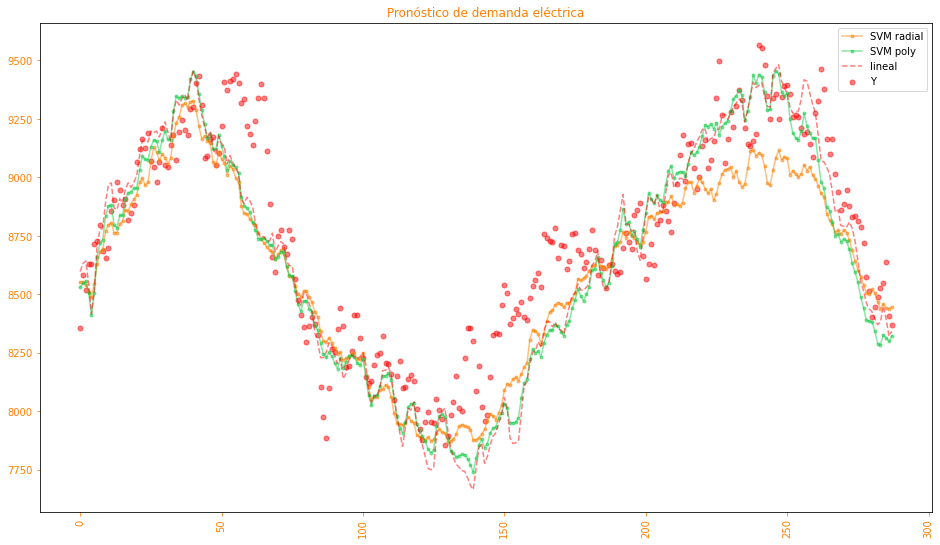

In [32]:
fig  = plt.figure(figsize=(16,9))
axes = fig.add_subplot(1, 1, 1)
#plt.style.use("seaborn-poster")
axes.legend()
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff';
mytitle = plt.title('Pronóstico de demanda eléctrica') # get the title property handler #plt.getp(title_obj)
plt.setp(mytitle,    color=LETRASNARA)                                        #set the color of title to red
axes.xaxis.label.set_color(LETRASNARA)
axes.yaxis.label.set_color(LETRASNARA)
axes.tick_params(colors=LETRASNARA, which='both')

AUX = np.arange( len(y_test) )
plt.scatter( AUX,y_test,s=25,marker='o' , color = 'red'      , label = 'Y'              ,alpha=1/2)
axes.plot  ( y_pred_rbf, '.-' , color = LETRASNARA , label = 'SVM radial'   ,alpha=1/2)
axes.plot  ( y_pred_poly, '.-' , color = VERDE , label = 'SVM poly'   ,alpha=1/2)
#axes.plot  ( y_local_list[1], '.-' , color = VERDE      , label = 'Y_local,k=25'   ,alpha=1/2)
#axes.plot  ( y_local_list[2], '.-' , color = AZUL       , label = 'Y_local,k=35'   ,alpha=1/2)
#axes.plot  ( y_local_list[3], '.-' , color = LILA       , label = 'Y_local,k=50'   ,alpha=1/2)
#axes.plot  ( y_local_list[4], '.-' , color = CYAN       , label = 'Y_local,k=100'  ,alpha=1/2)
axes.plot  ( y_lineal         , '--' , color = 'red'      , label = 'lineal'       ,alpha=1/2)
#axes.plot ( y      , '.-'  , color = 'red'        , label = 'Y'  ,alpha=1/2)
#axes.plot ( y_local, '.-'  , color = LETRASNARA   , label = 'Y_local'  ,alpha=1/2)
#axes.plot ( xspline[3], yspline[3] , '.-'  , color = VERDE   , label = 'orden=4'  ,alpha=1/2)
#axes.plot ( xspline[4], yspline[4] , '.-'  , color = AZUL   , label = 'orden=5'  ,alpha=1/12)
#plt.scatter( dfx_miss, dfy_miss, marker='x',  s=170 ,  color = 'red' , label = 'perdidos' ,alpha=1)

#plt.axis([0,  600, 7650, 9800])
#plt.axis([100,  200, 7650, 9500])
#plt.axis([400,  500, 7450, 9500])
#plt.axis([-2,  100, 8100, 9600])
#plt.axis([300, 400, 7900, 9500])
plt.legend()  
plt.xticks(rotation=90)
plt.savefig('pronodemanda_t12_1.png', transparent=True)
plt.show()

In [38]:
print('| REGRESIÓN      | MAE            | MSD            | MAPE         | ')
print('| :------------- | -------------: | -------------: |-------------:|')
print('|    lineal      |',str(mae_rlm),'      |',str(mse_rlm),'    |    ',str(mape_rlm),'  |' )
print('|    SVM rbf     |',str(mae_rbf),'      |',str(mse_rbf),'    |    ',str(mape_rbf),'  |' )
print('|    SVM poly     |',str(mae_poly),'      |',str(mse_poly),'    |    ',str(mape_poly),'  |' )

| REGRESIÓN      | MAE            | MSD            | MAPE         | 
| :------------- | -------------: | -------------: |-------------:|
|    lineal      | 167.1343       | 48064.1398     |     0.0192   |
|    SVM rbf     | 171.2803       | 47066.8569     |     0.0193   |
|    SVM rbf     | 170.7314       | 47944.1659     |     0.0195   |


# **Graficamos el ajuste de todos los modelos**

[Support Vector Machine - Regression (SVR) ****](http://www.saedsayad.com/support_vector_machine_reg.htm)


[https://towardsdatascience.com/an-introduction-to-support-vector-regression-svr-a3ebc1672c2](https://towardsdatascience.com/an-introduction-to-support-vector-regression-svr-a3ebc1672c2)

[Grid Search over C and Epsilon](https://github.com/tomsharp/SVR/blob/master/SVR.ipynb)

https://scikit-learn.org/stable/modules/svm.html

https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html

https://medium.com/pursuitnotes/support-vector-regression-in-6-steps-with-python-c4569acd062d

https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/?utm_source=blog&utm_medium=support-vector-regression-tutorial-for-machine-learning

In [34]:
#print('| REGRESIÓN      | C              | MAE            | MSD            | MAPE         | % WITHIN EPSILON = ',epsilon,'       |')
#print('| :------------- | :------------- | -------------: | -------------: |-------------:|-------------:|')
#print('|    lineal      |         ',       0,'    |    ',str(mae_rlm),'  |    ',str(mse_rlm),'    |    ',str(mape_rlm),'|' )
#for i in range(len(Clist)):
#    print('|     SVM        |       ',  Clist[i]  ,'    |    ',str(mae_svm[i]),'   |    ',
#       str(mse_svm[i]),'    |    ',str(mape_svm[i]),'    |    ',str(perc_within_eps_list[i]),'|',)
